# Binning

In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function

In [3]:
from collections import OrderedDict
from copy import deepcopy
from itertools import product
from os import *
from os.path import *
import pickle
import sys

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
plt.style.use('default')

sys.path.append(abspath('..'))
from retro.utils.geom import powerspace, generate_digitizer

from plotGoodies import removeBorder

In [4]:
outdir = 'table_binning'
if not isdir(outdir):
    makedirs(outdir)

The very first set of tables was binned as

The second set of tables used Spice Mie (no tilt, and by definition no anisotropy) and h2-50cm hole ice model.
These files/tables are prefixed by `large_5d_notilt*`.

The base table set was binned as follows (note that there was an attempt to reorder the binning, which I'm ignoring for now)

In [5]:
bin_edges2 = OrderedDict([
    ('r', powerspace(0.0, 400.0, 101, 2)),
    ('costheta', np.linspace(-1.0, 1.0, 41)),
    ('t', np.linspace(0.0, 3000.0, 251)),
    ('costhetadir', np.linspace(-1.0, 1.0, 81)),
    ('deltaphidir', np.linspace(0.0, 3.14159265359, 41))
])

n_bins2 = np.product([len(be) - 1 for be in bin_edges2.values()])
print('{:.3e} bins, {:.3f} GiB'.format(n_bins2, n_bins2*4/1024**3))

3.200e+09 bins, 11.921 GiB


But due to the overflow bins, the original CLSim table actually took up

In [6]:
n_clsim_bins2 = np.product([len(be) + 1 for be in bin_edges2.values()])
print('{:.3f} GiB'.format(n_clsim_bins2 * 4 / 1024**3))

13.851 GiB


And we must keep in mind CLSim uses uint32 for "flattened" bin number, so we cannot exceed

In [7]:
print(2**32, 'bins, TOTAL')

4294967296 bins, TOTAL


In [8]:
2**32 / n_clsim_bins2

1.155172164792273

In [9]:
dr = np.diff(bin_edges2['r'])
dt = np.diff(bin_edges2['t'])
ddpdir = np.rad2deg(np.diff(bin_edges2['deltaphidir']))
print(dr, 'm')
print(dt[0], 'ns')
print(ddpdir[0], 'deg')

[0.04 0.12 0.2  0.28 0.36 0.44 0.52 0.6  0.68 0.76 0.84 0.92 1.   1.08
 1.16 1.24 1.32 1.4  1.48 1.56 1.64 1.72 1.8  1.88 1.96 2.04 2.12 2.2
 2.28 2.36 2.44 2.52 2.6  2.68 2.76 2.84 2.92 3.   3.08 3.16 3.24 3.32
 3.4  3.48 3.56 3.64 3.72 3.8  3.88 3.96 4.04 4.12 4.2  4.28 4.36 4.44
 4.52 4.6  4.68 4.76 4.84 4.92 5.   5.08 5.16 5.24 5.32 5.4  5.48 5.56
 5.64 5.72 5.8  5.88 5.96 6.04 6.12 6.2  6.28 6.36 6.44 6.52 6.6  6.68
 6.76 6.84 6.92 7.   7.08 7.16 7.24 7.32 7.4  7.48 7.56 7.64 7.72 7.8
 7.88 7.96] m
12.0 ns
4.500000000000297 deg


Tables we will generate now could be the following:

In [10]:
bin_edges3 = OrderedDict([
    ('costheta', np.linspace(-1.0, 1.0, 41)),
    ('phi', np.linspace(0.0, np.pi, 41)),
    ('r', powerspace(0.0, 400.0, 51, 2)),
    ('t', powerspace(0.0, 4000.0, 51, 2)),
    ('costhetadir', np.linspace(-1.0, 1.0, 41)),
    ('deltaphidir', powerspace(0.0, 3.14159265359, 19, 2))
])

n_bins3 = np.product([len(be) - 1 for be in bin_edges3.values()])
n_clsim_bins3 = np.product([len(be) + 1 for be in bin_edges3.values()])
if n_clsim_bins3 >= 2**32:
    print('{:.3e} times too many bins'.format(n_clsim_bins3 / 2.**32))

print('{:.3e} CLSim-table bins ({:.3f} GiB), {:.3e} no-overflow bins ({:.3f} GiB)'.format(
    n_clsim_bins3, n_clsim_bins3*4/1024**3,
    n_bins3, n_bins3*4/1024**3
))

4.007e+09 CLSim-table bins (14.926 GiB), 2.880e+09 no-overflow bins (10.729 GiB)


In [11]:
dr = np.diff(bin_edges3['r'])
dt = np.diff(bin_edges3['t'])
ddpdir = np.rad2deg(np.diff(bin_edges3['deltaphidir']))
print(dr, 'm')
print(dt, 'ns')
print(ddpdir, 'deg')

[ 0.16  0.48  0.8   1.12  1.44  1.76  2.08  2.4   2.72  3.04  3.36  3.68
  4.    4.32  4.64  4.96  5.28  5.6   5.92  6.24  6.56  6.88  7.2   7.52
  7.84  8.16  8.48  8.8   9.12  9.44  9.76 10.08 10.4  10.72 11.04 11.36
 11.68 12.   12.32 12.64 12.96 13.28 13.6  13.92 14.24 14.56 14.88 15.2
 15.52 15.84] m
[  1.6   4.8   8.   11.2  14.4  17.6  20.8  24.   27.2  30.4  33.6  36.8
  40.   43.2  46.4  49.6  52.8  56.   59.2  62.4  65.6  68.8  72.   75.2
  78.4  81.6  84.8  88.   91.2  94.4  97.6 100.8 104.  107.2 110.4 113.6
 116.8 120.  123.2 126.4 129.6 132.8 136.  139.2 142.4 145.6 148.8 152.
 155.2 158.4] ns
[ 0.55555556  1.66666667  2.77777778  3.88888889  5.          6.11111111
  7.22222222  8.33333333  9.44444444 10.55555556 11.66666667 12.77777778
 13.88888889 15.         16.11111111 17.22222222 18.33333333 19.44444444] deg


In [12]:
bin_edges4 = OrderedDict([
    ('costheta', np.linspace(-1.0, 1.0, 61)),
    ('r', powerspace(0.0, 400.0, 101, 2)),
    ('dt', powerspace(0.0, 4000.0, 101, 2)),
    ('costhetadir', np.linspace(-1.0, 1.0, 61)),
    ('deltaphidir', np.linspace(0.0, 3.14159265359, 31))
])

n_bins4 = np.product([len(be) - 1 for be in bin_edges4.values()])
n_clsim_bins4 = np.product([len(be) + 1 for be in bin_edges4.values()])
if n_clsim_bins4 >= 2**32:
    print('{:.3e} times too many bins'.format(n_clsim_bins4 / 2.**32))

print('{:.3e} CLSim-table bins ({:.3f} GiB), {:.3e} no-overflow bins ({:.3f} GiB)'.format(
    n_clsim_bins4, n_clsim_bins4*4/1024**3,
    n_bins4, n_bins4*4/1024**3
))

1.280e+09 CLSim-table bins (4.768 GiB), 1.080e+09 no-overflow bins (4.023 GiB)


In [13]:
dr = np.diff(bin_edges4['r'])
dt = np.diff(bin_edges4['dt'])
ddpdir = np.rad2deg(np.diff(bin_edges4['deltaphidir']))
print(dr, 'm')
print(dt, 'ns')
print(ddpdir, 'deg')

[0.04 0.12 0.2  0.28 0.36 0.44 0.52 0.6  0.68 0.76 0.84 0.92 1.   1.08
 1.16 1.24 1.32 1.4  1.48 1.56 1.64 1.72 1.8  1.88 1.96 2.04 2.12 2.2
 2.28 2.36 2.44 2.52 2.6  2.68 2.76 2.84 2.92 3.   3.08 3.16 3.24 3.32
 3.4  3.48 3.56 3.64 3.72 3.8  3.88 3.96 4.04 4.12 4.2  4.28 4.36 4.44
 4.52 4.6  4.68 4.76 4.84 4.92 5.   5.08 5.16 5.24 5.32 5.4  5.48 5.56
 5.64 5.72 5.8  5.88 5.96 6.04 6.12 6.2  6.28 6.36 6.44 6.52 6.6  6.68
 6.76 6.84 6.92 7.   7.08 7.16 7.24 7.32 7.4  7.48 7.56 7.64 7.72 7.8
 7.88 7.96] m
[ 0.4  1.2  2.   2.8  3.6  4.4  5.2  6.   6.8  7.6  8.4  9.2 10.  10.8
 11.6 12.4 13.2 14.  14.8 15.6 16.4 17.2 18.  18.8 19.6 20.4 21.2 22.
 22.8 23.6 24.4 25.2 26.  26.8 27.6 28.4 29.2 30.  30.8 31.6 32.4 33.2
 34.  34.8 35.6 36.4 37.2 38.  38.8 39.6 40.4 41.2 42.  42.8 43.6 44.4
 45.2 46.  46.8 47.6 48.4 49.2 50.  50.8 51.6 52.4 53.2 54.  54.8 55.6
 56.4 57.2 58.  58.8 59.6 60.4 61.2 62.  62.8 63.6 64.4 65.2 66.  66.8
 67.6 68.4 69.2 70.  70.8 71.6 72.4 73.2 74.  74.8 75.6 76.4 77.2 

In [14]:
bin_edges4['dt']

array([0.0000e+00, 4.0000e-01, 1.6000e+00, 3.6000e+00, 6.4000e+00,
       1.0000e+01, 1.4400e+01, 1.9600e+01, 2.5600e+01, 3.2400e+01,
       4.0000e+01, 4.8400e+01, 5.7600e+01, 6.7600e+01, 7.8400e+01,
       9.0000e+01, 1.0240e+02, 1.1560e+02, 1.2960e+02, 1.4440e+02,
       1.6000e+02, 1.7640e+02, 1.9360e+02, 2.1160e+02, 2.3040e+02,
       2.5000e+02, 2.7040e+02, 2.9160e+02, 3.1360e+02, 3.3640e+02,
       3.6000e+02, 3.8440e+02, 4.0960e+02, 4.3560e+02, 4.6240e+02,
       4.9000e+02, 5.1840e+02, 5.4760e+02, 5.7760e+02, 6.0840e+02,
       6.4000e+02, 6.7240e+02, 7.0560e+02, 7.3960e+02, 7.7440e+02,
       8.1000e+02, 8.4640e+02, 8.8360e+02, 9.2160e+02, 9.6040e+02,
       1.0000e+03, 1.0404e+03, 1.0816e+03, 1.1236e+03, 1.1664e+03,
       1.2100e+03, 1.2544e+03, 1.2996e+03, 1.3456e+03, 1.3924e+03,
       1.4400e+03, 1.4884e+03, 1.5376e+03, 1.5876e+03, 1.6384e+03,
       1.6900e+03, 1.7424e+03, 1.7956e+03, 1.8496e+03, 1.9044e+03,
       1.9600e+03, 2.0164e+03, 2.0736e+03, 2.1316e+03, 2.1904e

In [15]:
bin_edges3 = OrderedDict([
    ('r', powerspace(0.0, 400.0, 101, 2)),
    ('costheta', np.linspace(-1.0, 1.0, 41)),
    ('phi', np.linspace(0, 2*np.pi, 81)),
    ('t', np.linspace(0.0, 4000.0, 101)),
])

n_bins3 = np.product([len(be) - 1 for be in bin_edges3.values()])
print('{:.3e} bins, {:.3f} GiB'.format(n_bins3, n_bins3*6/1024**3))
print('{:7.3f} GiB for 5160 tables'.format(n_bins3*5160*6/1024**3))
print('{:7.3f} GiB for  120 tables'.format(n_bins3*120*6/1024**3))

3.200e+07 bins, 0.179 GiB
922.680 GiB for 5160 tables
 21.458 GiB for  120 tables


In [16]:
bin_edges3_raw = deepcopy(bin_edges3)
bin_edges3_raw['costhetadir'] = np.linspace(-1.0, 1.0, 81)
bin_edges3_raw['deltaphidir'] = np.linspace(0.0, 3.14159265359, 41)

n_bins3_raw = np.product([len(be) - 1 for be in bin_edges3_raw.values()])
print('{:.3e} bins, {:.3f} GiB'.format(n_bins3_raw, n_bins3_raw*6/1024**3))
print('{:7.3f} PiB for 5160 tables'.format(n_bins3_raw*5160*6/1024**5))
print('{:7.3f} TiB for  120 tables'.format(n_bins3_raw*120*6/1024**4))

1.024e+11 bins, 572.205 GiB
  2.816 PiB for 5160 tables
 67.055 TiB for  120 tables


If we can use templates to compress the $\cos\theta_{\rm dir}$ and $\Delta\phi_{\rm dir}$ as before, but then we the scale $\cos\theta$ and $\phi$ spatial dimensions and then use another set of templates to also compress the 

In [17]:
# zip(binning.names, binning.num_bins)

In [18]:
# binning.domains

In [19]:
bin_edges = OrderedDict([
    ('r', powerspace(0.0, 200.0, 81, 2)),
    ('costheta', np.linspace(-1.0, 1.0, 41)),
    #('phi', np.linspace(0.0, np.pi, 41)),
    ('dt', powerspace(0.0, 4000.0, 101, 2)),
    ('costhetadir', np.linspace(-1.0, 1.0, 41)),
    ('deltaphidir', np.linspace(0, np.pi, 41))
])

n_bins = np.product([len(be) - 1 for be in bin_edges.values()])
n_clsim_bins = np.product([len(be) + 1 for be in bin_edges.values()])
if n_clsim_bins >= 2**32:
    print('{:.2f} times too many bins'.format(n_clsim_bins / 2.**32))

bytes_per_bin = 4 # float32

print('{:.3e} CLSim-table bins ({:.3f} GiB), {:.3e} no-overflow bins ({:.3f} GiB)'.format(
    n_clsim_bins, n_clsim_bins*bytes_per_bin/(1024**3),
    n_bins, n_bins*bytes_per_bin/1024**3
))
print('{:7.3f} TiB for 5160 tables'.format(n_clsim_bins*5160*bytes_per_bin/(1024**4)))

np.set_printoptions(precision=3, suppress=True)
print(bin_edges['r'][:100], 'm')
print(bin_edges['dt'][:20], 'ns')

6.197e+08 CLSim-table bins (2.308 GiB), 5.120e+08 no-overflow bins (1.907 GiB)
 11.632 TiB for 5160 tables
[  0.      0.031   0.125   0.281   0.5     0.781   1.125   1.531   2.
   2.531   3.125   3.781   4.5     5.281   6.125   7.031   8.      9.031
  10.125  11.281  12.5    13.781  15.125  16.531  18.     19.531  21.125
  22.781  24.5    26.281  28.125  30.031  32.     34.031  36.125  38.281
  40.5    42.781  45.125  47.531  50.     52.531  55.125  57.781  60.5
  63.281  66.125  69.031  72.     75.031  78.125  81.281  84.5    87.781
  91.125  94.531  98.    101.531 105.125 108.781 112.5   116.281 120.125
 124.031 128.    132.031 136.125 140.281 144.5   148.781 153.125 157.531
 162.    166.531 171.125 175.781 180.5   185.281 190.125 195.031 200.   ] m
[  0.    0.4   1.6   3.6   6.4  10.   14.4  19.6  25.6  32.4  40.   48.4
  57.6  67.6  78.4  90.  102.4 115.6 129.6 144.4] ns


## TDI table binning

If we want to coarsely bin (10 meter cubes) in general but finely bin the DeepCore sub-dust-layer region, then we have (strictly speaking):

Coarse binning (meters, excluding fine-binned region):

$x \in [-570.9, 576.4]$, $y \in [-521.1, 509.5]$, $z \in [-512.8, 524.6]$

Fine binning (meters):

$x \in [-77.8, 194.3]$, $y \in [-150.6, 82.4]$, $z \in [-510.6, -152.0]$

In [20]:
gcd = pickle.load(file('../data/GeoCalibDetectorStatus_2013.56429_V1_Modified.pkl', 'rb'))
geo = gcd['geo']

In [21]:
ic_xlims = [-570.9, 576.37]
ic_ylims = [-521.08, 509.5 ]
ic_zlims = [-512.82, 524.56]
ic_lims = (ic_xlims, ic_ylims, ic_zlims)

dcsd_xlims = [-77.8, 194.34]
dcsd_ylims = [-150.63, 82.35]
dcsd_zlims = [-510.57, -152.]
dcsd_lims = (dcsd_xlims, dcsd_ylims, dcsd_zlims)

# n_ic_x, n_ic_y, n_ic_z = n_ic_xyz = np.array([np.ceil((np.diff(i)[0] - np.diff(d)[0]) / 10) for i, d in zip(ic_lims, dcsd_lims)]).astype(int)
n_dcsd_x, n_dcsd_y, n_dcsd_z = n_dcsd_xyz = np.array([np.ceil(np.diff(d)[0] / 1) for d in dcsd_lims]).astype(int)
n_ic_xyz = np.product(np.array([np.ceil(np.diff(i)[0] / 10) for i in ic_lims]).astype(int)) - np.product(np.ceil(n_dcsd_xyz.astype(float)/10).astype(int))

print('n_ic_xyz', n_ic_xyz)
print('n_dcsd_xyz', np.product(n_dcsd_xyz))
n_xyz = n_ic_xyz + np.product(n_dcsd_xyz)
n_tot = n_xyz * 40 * 80
print('n_xyz', n_xyz)
print('n_tot', n_tot)
print('n_tot / 2**32', n_tot / 2**32)

n_ic_xyz 1219648
n_dcsd_xyz 22835631
n_xyz 24055279
n_tot 76976892800
n_tot / 2**32 17.922579497098923


In [22]:
ic_xlims = [-570.9, 576.37]
ic_ylims = [-521.08, 509.5 ]
ic_zlims = [-512.82, 524.56]

dcsd_xlims = [-77.8, 194.34]
dcsd_ylims = [-150.63, 82.35]
dcsd_zlims = [-510.57, -152.]

In [23]:
outdir

'table_binning'

IceCube: 2.536e+09 CLSim-table bins (9.447 GiB), 2.180e+09 no-overflow bins (8.121 GiB)
DeepCore: 3.600e+09 CLSim-table bins (13.412 GiB), 3.108e+09 no-overflow bins (11.578 GiB)
Number of redundant IceCube (coarse) bins due to fine binning: 2.486e+07 (94.849 MiB)
CPU times: user 25 s, sys: 208 ms, total: 25.2 s
Wall time: 25.3 s


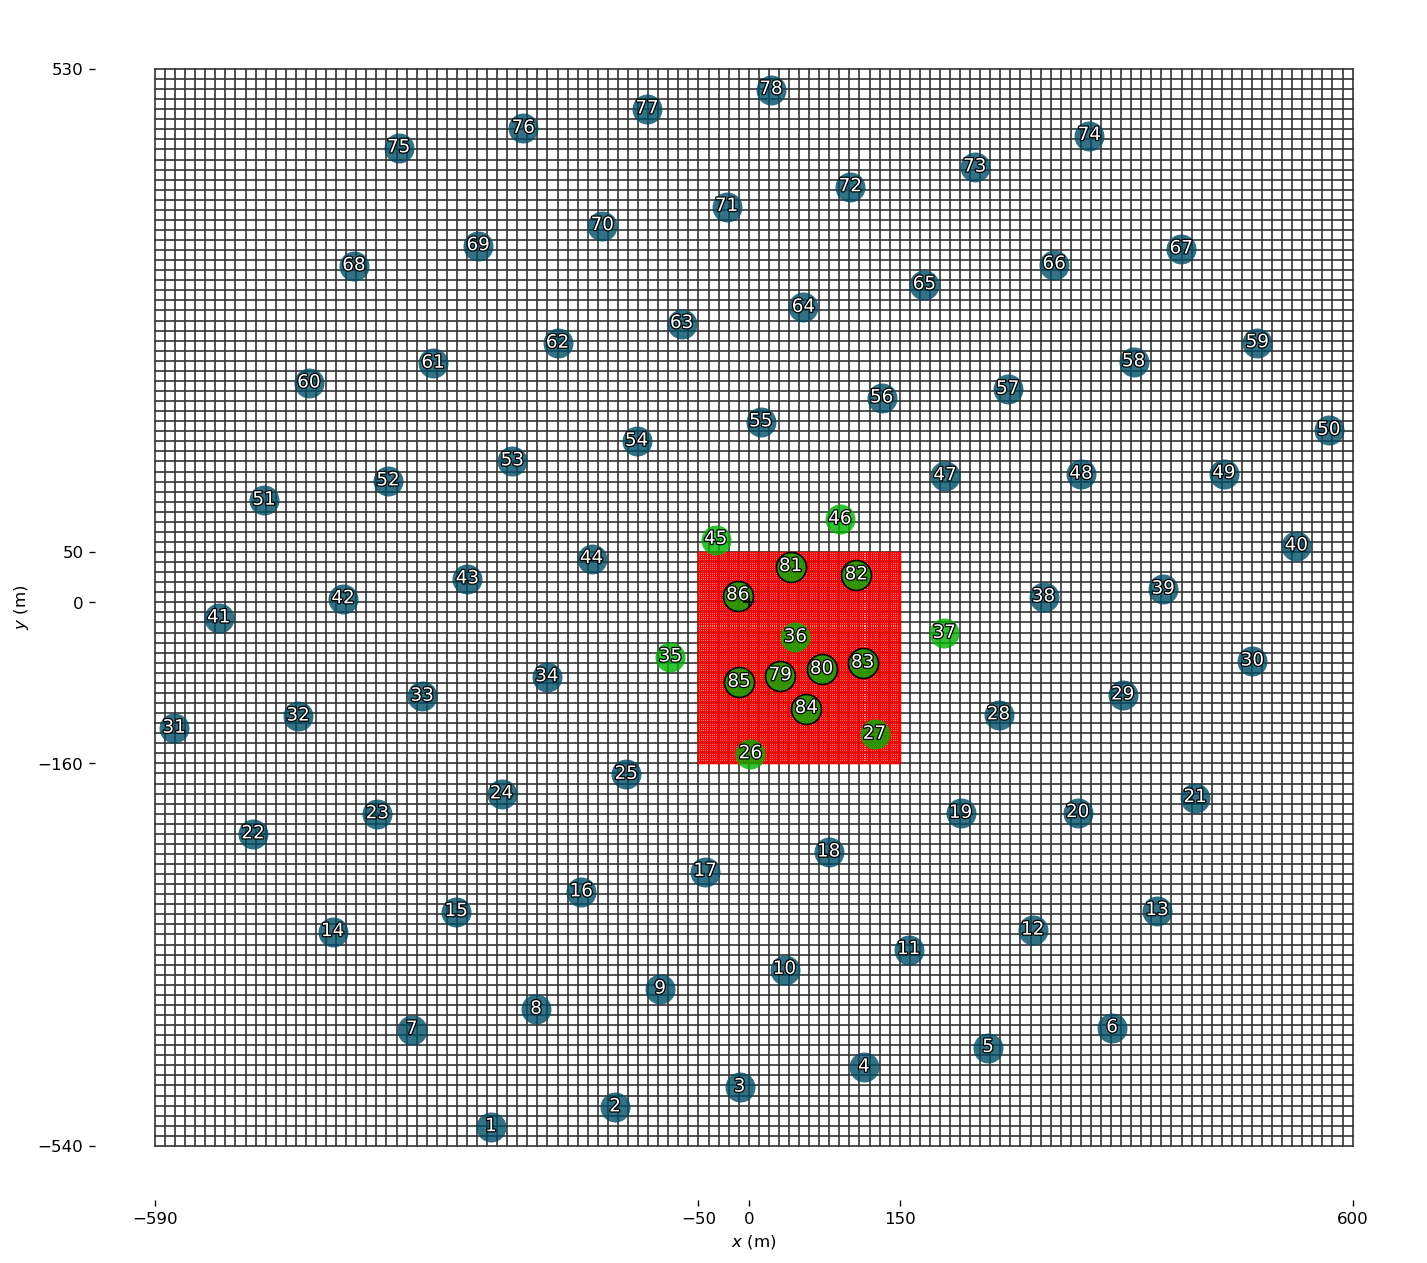

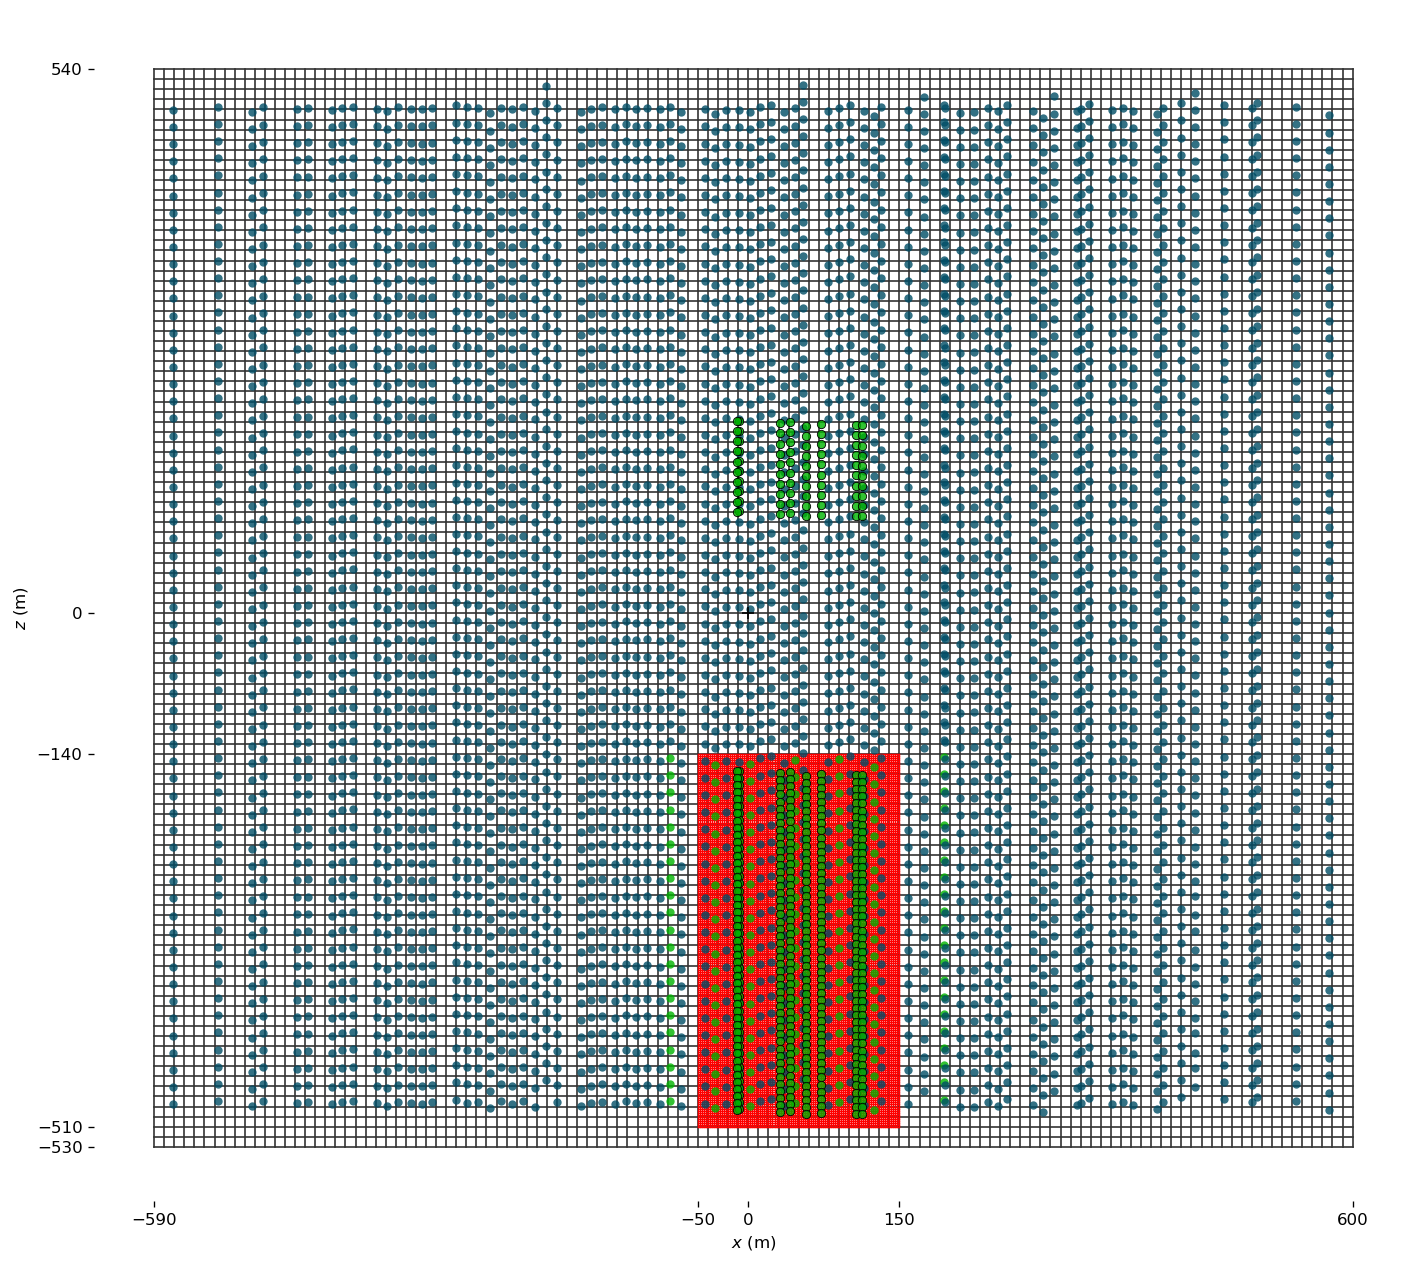

In [24]:
%%time

icb_xmin, icb_xmax = -590, 600
icb_ymin, icb_ymax = -540, 530
icb_zmin, icb_zmax = -530, 540
ic_binwidth = 10

dcb_xmin, dcb_xmax = -50, 150
dcb_ymin, dcb_ymax = -160, 50
dcb_zmin, dcb_zmax = -510, -140
dc_binwidth = 2

icb_bin_edges = OrderedDict([
    ('x', np.arange(icb_xmin, icb_xmax+1, ic_binwidth)),
    ('y', np.arange(icb_ymin, icb_ymax+1, ic_binwidth)),
    ('z', np.arange(icb_zmin, icb_zmax+1, ic_binwidth)),
    ('costhetadir', np.linspace(-1.0, 1.0, 41)),
    ('phidir', np.linspace(-np.pi, np.pi, 41))
])

n_bins = np.product([len(be) - 1 for be in icb_bin_edges.values()])
n_clsim_bins = np.product([len(be) + 1 for be in icb_bin_edges.values()])
if n_clsim_bins >= 2**32:
    print('{:.2f} times too many IC bins'.format(n_clsim_bins / 2**32))
print('IceCube: {:.3e} CLSim-table bins ({:.3f} GiB), {:.3e} no-overflow bins ({:.3f} GiB)'.format(
    n_clsim_bins, n_clsim_bins*4/1024**3,
    n_bins, n_bins*4/1024**3
))

dcb_bin_edges = OrderedDict([
    ('x', np.arange(dcb_xmin, dcb_xmax+1, dc_binwidth)),
    ('y', np.arange(dcb_ymin, dcb_ymax+1, dc_binwidth)),
    ('z', np.arange(dcb_zmin, dcb_zmax+1, dc_binwidth)),
    ('costhetadir', np.linspace(-1.0, 1.0, 41)),
    ('phidir', np.linspace(-np.pi, np.pi, 41))
])

n_bins = np.product([len(be) - 1 for be in dcb_bin_edges.values()])
n_clsim_bins = np.product([len(be) + 1 for be in dcb_bin_edges.values()])
if n_clsim_bins >= 2**32:
    print('{:.2f} times too many DC bins'.format(n_clsim_bins / 2**32))
print('DeepCore: {:.3e} CLSim-table bins ({:.3f} GiB), {:.3e} no-overflow bins ({:.3f} GiB)'.format(
    n_clsim_bins, n_clsim_bins*4/1024**3,
    n_bins, n_bins*4/1024**3
))

n_redundant_ic_bins = int((dcb_xmax - dcb_xmin) * (dcb_ymax - dcb_ymin) * (dcb_zmax - dcb_zmin) / 10**3) * 40 * 40
print('Number of redundant IceCube (coarse) bins due to fine binning: {:.3e} ({:.3f} MiB)'.format(
    n_redundant_ic_bins, n_redundant_ic_bins*4/1024**2
))

# -- PLOT BINNING & DOMS -- #

inv = lambda c: [1 - x for x in c]
#inv = lambda c: c

#fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12, 20), dpi=120, sharex=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 12), dpi=120)
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 14), dpi=120, sharex=True)

alpha = 1
c = inv([0.8]*3)
lw = 1
for x in icb_bin_edges['x']:
    ax.plot([x]*2, [icb_ymin, icb_ymax], '-', c=c, lw=lw, alpha=alpha)
    ax2.plot([x]*2, [icb_zmin, icb_zmax], '-', c=c, lw=lw, alpha=alpha)
for y in icb_bin_edges['y']:
    ax.plot([icb_xmin, icb_xmax], [y]*2, '-', c=c, lw=lw, alpha=alpha)
for z in icb_bin_edges['z']:
    ax2.plot([icb_xmin, icb_xmax], [z]*2, '-', c=c, lw=lw, alpha=alpha)

alpha = 1
c = [1, 0, 0]
lw = 0.8
for x in dcb_bin_edges['x']:
    ax.plot([x]*2, [dcb_ymin, dcb_ymax], '-', c=c, lw=lw, alpha=alpha)
    ax2.plot([x]*2, [dcb_zmin, dcb_zmax], '-', c=c, lw=lw, alpha=alpha)
for y in dcb_bin_edges['y']:
    ax.plot([dcb_xmin, dcb_xmax], [y]*2, '-', c=c, lw=lw, alpha=alpha)
for z in dcb_bin_edges['z']:
    ax2.plot([dcb_xmin, dcb_xmax], [z]*2, '-', c=c, lw=lw, alpha=alpha)

# Plot strings
dc_strings = list(range(79, 87))
dc_ext_strings = [26, 27, 35, 36, 37, 45, 46]

alpha = 0.8
mfc_dc = [0.0, 0.7, 0.0, alpha]
mfc_ic = [0.0, 0.3, 0.4, alpha]
mec_dc = [0]*3
mec_ic = 'none'

texts = []
for s in range(1, 87):
    s_idx = s - 1
    x, y = geo[s_idx, 0, :2]
    mec = mec_dc if s in dc_strings else mec_ic
    ax.plot(
        x, y, 'o', ms=18,
        mfc=mfc_dc if s in (dc_strings + dc_ext_strings) else mfc_ic,
        mec=mec,
        mew=1,
    )
    txt = ax.text(
        x, y, str(s),
        fontdict=dict(fontsize=11),
        ha='left', va='bottom', color='w',
    )
    txt.set_path_effects([
        path_effects.Stroke(linewidth=1.5, foreground='black'),
        path_effects.Normal()
    ])
    texts.append(txt)
    for d in range(1, 60):
        d_idx = d - 1
        z = geo[s_idx, d_idx, 2]
        ax2.plot(
            x, z, 'o',
            ms=5,
            mfc=mfc_dc if (s in dc_strings or (s in dc_ext_strings and z < dcb_zmax)) else mfc_ic,
            mec=mec,
            mew=0.5,
        )

# Plot origin
ax.plot(0, 0, 'k+', mew=1, ms=7)
ax2.plot(0, 0, 'k+', mew=1, ms=7)

for axis in [ax, ax2]:
    axis.axis('image')
    removeBorder(axis, left=False, bottom=False)
    axis.yaxis.tick_left()
    axis.xaxis.tick_bottom()

ax.set_xticks([icb_xmin, dcb_xmin, 0, dcb_xmax, icb_xmax])
ax.set_yticks([icb_ymin, dcb_ymin, 0, dcb_ymax, icb_ymax])
ax.set_xlabel(r'$x$ (m)')
ax.set_ylabel(r'$y$ (m)')

ax2.set_xticks([icb_xmin, dcb_xmin, 0, dcb_xmax, icb_xmax])
ax2.set_yticks([icb_zmin, dcb_zmin, 0, dcb_zmax, icb_zmax])
ax2.set_xlabel(r'$x$ (m)')
ax2.set_ylabel(r'$z$ (m)')

fig.tight_layout() #h_pad=0.001, w_pad=0.001)
fig2.tight_layout() #h_pad=0.001, w_pad=0.001)
plt.draw()

transf = ax.transData.inverted()
for txt in texts:
    bb = txt.get_window_extent(renderer=fig.canvas.renderer)
    bb_datacoords = bb.transformed(transf)
    x0, y0, width, height = bb_datacoords.bounds
    txt.set_position((x0 - width/2, y0 - height/2 - height/20))
plt.draw()

fig.tight_layout() #h_pad=0.001, w_pad=0.001)
fig2.tight_layout() #h_pad=0.001, w_pad=0.001)

fpath = join(outdir, 'tdi_tables_binning_xy')
fig.savefig(fpath + '.pdf', transparent=True)
fig.savefig(fpath + '.png', dpi=120, transparent=True)

fpath = join(outdir, 'tdi_tables_binning_xz')
fig2.savefig(fpath + '.pdf', transparent=True)
fig2.savefig(fpath + '.png', dpi=120, transparent=True)
pass

In [25]:
n_redundant_ic_bins = int((dcb_xmax - dcb_xmin) * (dcb_ymax - dcb_ymin) * (dcb_zmax - dcb_zmin) / 10**3) * 40 * 40
print('Number of redundant IceCube (coarse) bins due to fine binning: {} ({} MiB)'.format(n_redundant_ic_bins, n_redundant_ic_bins*4/1024**2))

Number of redundant IceCube (coarse) bins due to fine binning: 24864000 (94.8486328125 MiB)


## Split up big TDI tables into smaller pieces for single-DOM sims

Because
* Producing 5160 of each of the IC and DC TDI tables would certainly take too much space.
* Producing and combining tables simultaneously would get around the space requirements, but would require more code complexity and any issues during the combination (think file locking, race conditions, erroneous norm) would require re-simulating _all_ tables.

I have decided to simply generate smaller tables, where limits of the tables are relative to the DOM positions (e.g. the extents could be 200 m East/West/North/South of each DOM).
* There will still be 5160 tables for IC existing simultaneously on disk, but there should be fewer DC tables since outermost DOMs are > 200 m away from DC region. Worst case, though, would be 2$\times$5160
* However, each table should be relatively small (and 

In [26]:
rel_extent = 200 # meters from DOM coordinate in -x, +x, -y, +y, -z, +z
rel_extents = np.array([-rel_extent, rel_extent])

icb_lims = dict(x=[icb_xmin, icb_xmax], y=[icb_ymin, icb_ymax], z=[icb_zmin, icb_zmax])
dcb_lims = dict(x=[dcb_xmin, dcb_xmax], y=[dcb_ymin, dcb_ymax], z=[dcb_zmin, dcb_zmax])

def generate_digitizer(edges):
    x0 = np.min(edges)
    x1 = np.max(edges)
    n = len(edges) - 1
    dx = (x1 - x0) / n
    def dig(val):
        return np.int64((val - x0) / dx)
    return dig

ic_dig = {d: generate_digitizer(edges) for d, edges in icb_bin_edges.items()}
dc_dig = {d: generate_digitizer(edges) for d, edges in dcb_bin_edges.items()}

### IceCube binning

In [27]:
icb_bin_edges.keys()

['x', 'y', 'z', 'costhetadir', 'phidir']

In [28]:
n_czdir_bins = len(icb_bin_edges['costhetadir']) - 1
n_phidir_bins = len(icb_bin_edges['phidir']) - 1

ic_tdi_idxs = OrderedDict()
ic_tdi_extents = OrderedDict()
for string, dom in product(range(1, 87), range(1, 61)):
    s_idx = string - 1
    d_idx = dom - 1
    skip = False
    x0, y0, z0 = geo[s_idx, d_idx]
    coord = dict(x=x0, y=y0, z=z0)
    dom_tdi_extents = OrderedDict()
    dom_tdi_idxs = OrderedDict()
    for dim in ['x', 'y', 'z']:
        extents = np.clip(coord[dim] + rel_extents, icb_lims[dim][0], icb_lims[dim][1])
        if extents[1] - extents[0] <= 0:
            skip = True
            break
        idxs = np.array([ic_dig[dim](_) for _ in extents])
        dom_tdi_idxs[dim] = idxs
        dom_tdi_extents[dim] = idxs * ic_binwidth + icb_lims[dim][0]
        
    if skip:
        continue
    dom_tdi_idxs['costhetadir'] = np.array([0, n_czdir_bins - 1])
    dom_tdi_idxs['phidir'] = np.array([0, n_phidir_bins - 1])
    
    ic_tdi_idxs[(string, dom)] = dom_tdi_idxs
    ic_tdi_extents[(string, dom)] = dom_tdi_extents
    
ic_nbins_tot = np.sum([np.product([(i[-1] - i[0] + 1 + 2) for i in dom_tdi_idxs.values()]) for dom_tdi_idxs in ic_tdi_idxs.values()])
ic_nbins_no_overflow = np.sum([np.product([(i[-1] - i[0] + 1) for i in dom_tdi_idxs.values()]) for dom_tdi_idxs in ic_tdi_idxs.values()])

Number of tables to generate

In [29]:
len(ic_tdi_idxs)

5160

Total tables' size, as generated by CLSim (including under/overflow)

In [30]:
print('{:.3f} TiB'.format(ic_nbins_tot * 4 / 1024**4))

2.211 TiB


Total tables' size removing under/overflow

In [31]:
print('{:.3f} TiB'.format(ic_nbins_no_overflow * 4 / 1024**4))

1.723 TiB


### DeepCore-region binning

In [32]:
n_czdir_bins = len(dcb_bin_edges['costhetadir']) - 1
n_phidir_bins = len(dcb_bin_edges['phidir']) - 1

dc_tdi_idxs = OrderedDict()
dc_tdi_extents = OrderedDict()
for string, dom in product(range(1, 87), range(1, 61)):
    s_idx = string - 1
    d_idx = dom - 1
    skip = False
    x0, y0, z0 = geo[s_idx, d_idx]
    coord = dict(x=x0, y=y0, z=z0)
    dom_tdi_extents = OrderedDict()
    dom_tdi_idxs = OrderedDict()
    for dim in ['x', 'y', 'z']:
        extents = np.clip(coord[dim] + rel_extents, dcb_lims[dim][0], dcb_lims[dim][1])
        if extents[1] - extents[0] == 0:
            skip = True
            break
        idxs = np.array([dc_dig[dim](_) for _ in extents])
        dom_tdi_idxs[dim] = idxs
        dom_tdi_extents[dim] = idxs * dc_binwidth + dcb_lims[dim][0]
        
    if skip:
        continue
    dom_tdi_idxs['costhetadir'] = np.array([0, n_czdir_bins - 1])
    dom_tdi_idxs['phidir'] = np.array([0, n_phidir_bins - 1])
    
    dc_tdi_idxs[(string, dom)] = dom_tdi_idxs
    dc_tdi_extents[(string, dom)] = dom_tdi_extents

dc_nbins_tot = np.sum([np.product([(i[-1] - i[0] + 1 + 2) for i in dom_tdi_idxs.values()]) for dom_tdi_idxs in dc_tdi_idxs.values()])
dc_nbins_no_overflow = np.sum([np.product([(i[-1] - i[0] + 1) for i in dom_tdi_idxs.values()]) for dom_tdi_idxs in dc_tdi_idxs.values()])

Number of tables to generate

In [33]:
len(dc_tdi_idxs)

1312

Total tables' size, as generated by CLSim (including under/overflow)

In [34]:
print('{:.3f} TiB'.format(dc_nbins_tot * 4 / 1024**4))

7.672 TiB


Total tables' size removing under/overflow

In [35]:
print('{:.3f} TiB'.format(dc_nbins_no_overflow * 4 / 1024**4))

6.541 TiB


### Total size of all tables

Including overflow bins:

In [36]:
print('{:.3f} TiB'.format((ic_nbins_tot + dc_nbins_tot) * 4 / 1024**4))

9.883 TiB


Excluding overflow bins:

In [37]:
print('{:.3f} TiB'.format((ic_nbins_no_overflow + dc_nbins_no_overflow) * 4 / 1024**4))

8.265 TiB


In [38]:
dc_dig['x'](940)

495

In [39]:
dig = generate_digitizer([0, 1, 2])

In [40]:
dig(0), dig(2)

(0, 2)

In [41]:
99 * 10 -50

940

In [42]:
extents

array([-510.  , -300.73])

In [43]:
idxs

array([  0, 104])

### Save info to disk for use by table generator script

#### Define function for producing needed files

In [44]:
def generate_script(seed, n_events, tilt, anisotropy, binwidth, tdi_idxs, tdi_extents):
    tbl_idx = 0
    lines = []
    spacing = binwidth # meters
    for (string, dom), extents in tdi_extents.items():
        idxs = tdi_idxs[(string, dom)]
        line = '{:d} {:d} {:d} {:d} {:d}'.format(tbl_idx, string, dom, seed, n_events)
        nbins = 1
        for dim in ['x', 'y', 'z']:
            lower = extents[dim][0]
            upper = extents[dim][1]
            n = idxs[dim][-1] - idxs[dim][0]
            line += ' {} {} {}'.format(lower, upper, n)
            nbins *= n + 2
        line += ' {} {}'.format(n_czdir_bins, n_phidir_bins)
        nbins *= (n_czdir_bins + 2) * (n_phidir_bins + 2)
        if nbins > 2**32:
            raise ValueError('Too many bins: {} (cannot have more than {})'
                           .format(nbins, 2**32))
        lines.append(line)
        tbl_idx += 1

    # NOTE: You need the final newline for the last line to be used by `read`!
    fpath = join(outdir, 'tdi_tiles_to_produce.txt')
    with file(fpath, 'w') as f:
        f.write('\n'.join(lines) + '\n')
    md5 = os.popen('md5sum {}'.format(fpath)).read().split()[0][:8]

    tilt_onoff = 'on' if tilt else 'off'
    anisotropy_onoff = 'on' if anisotropy else 'off'

    new_fpath = '{}.{}.tilt_{}_anisotropy_{}.txt'.format(
        fpath.split('.txt')[0],
        md5,
        tilt_onoff,
        anisotropy_onoff,
    )
    os.rename(fpath, new_fpath)
    fpath = new_fpath

    print('Lines in file "{}" (tables to be produced): {}'.format(fpath, len(lines)))
    print('\nFirst few lines:')
    print('\n'.join(lines[:5]))
    print('\nLast few lines:')
    print('\n'.join(lines[-5:]))

    script = r"""#!/bin/bash

[ -n "$PARROT_CVMFS_ALIEN_CACHE" ] && rm -rf $PARROT_CVMFS_ALIEN_CACHE/*

export TABLESET_HASH={md5:s}

basename="tdi_${{TABLESET_HASH}}_tilt_{tilt_onoff:s}_anisotropy_{anisotropy_onoff:s}"
export OUTDIR="/gpfs/scratch/$USER/$basename"
mkdir -p "$OUTDIR"
cp "{fpath:s}" "$OUTDIR/"

qfile=$HOME/rqs_${{basename}}.tmp

export SLAVE_SCRIPT="/storage/home/jll1062/cowen/pbs/generate_clsim_cartesian_table.sh"
export ENV_SHELL="/gpfs/group/dfc13/default/build/i3/retro/spicelea/env-shell.sh"
export GCD="GeoCalibDetectorStatus_2013.56429_V1_Modified.i3.gz"
export ICE_MODEL="spice_lea"
export ANGULAR_SENSITIVITY="9"
export DISABLE_ANISOTROPY={disable_anisotropy:d}
export DISABLE_TILT={disable_tilt:d}

max_parallel=100
max_in_q1=346
max_in_q2=80
max_in_q3=1080
max_in_all_queues=4000

avail=0
while read -r tile string dom seed n_events x_min x_max n_x y_min y_max n_y z_min z_max n_z n_czdir_bins n_phidir_bins
do
    export TILE=$tile
    export STRING=$string
    export DOM=$dom
    export SEED=$seed
    export N_EVENTS=$n_events
    export N_X_BINS=$n_x
    export N_Y_BINS=$n_y
    export N_Z_BINS=$n_z
    export N_T_BINS=0
    export N_COSTHETADIR_BINS=$n_czdir_bins
    export N_PHIDIR_BINS=$n_phidir_bins
    export X_MIN=$x_min
    export X_MAX=$x_max
    export Y_MIN=$y_min
    export Y_MAX=$y_max
    export Z_MIN=$z_min
    export Z_MAX=$z_max

    job_name=t${{TABLESET_HASH}}${{DISABLE_TILT}}${{DISABLE_ANISOTROPY}}${{TILE}}
    printf ">> Job name: %s :" $job_name

    # Has tile already been produced?
    printf " Checking if file exists:"
    [ -f $OUTDIR/clsim_table_set_${{TABLESET_HASH}}_tile_${{TILE}}_string_${{STRING}}_dom_${{DOM}}_seed_${{SEED}}_n_${{N_EVENTS}}.fits ] && printf " Yes; moving on.\n" && continue
    printf " No."

    while (( avail <= 0 )) ; do
        printf " Gathering queue info: "

        while (( 1 )) ; do
            qstat_aci.py -f --state r q s --detail job_name --user $USER >$qfile 2>&1 && break
            printf " qstat_aci.py failed; sleeping."
            sleep 0.5
        done
        printf " Done."

        printf " Computing availability"
        q1_avail=$(( max_in_q1 - $( qstat_aci.py --cq cyberlamp --detail job_name --state r q s --user $USER | wc -l ) ))
        printf "."
        q2_avail=$(( max_in_q2 - $( qstat_aci.py --cq aci dfc13_a_g_sc_default --detail job_name --state r q s --user $USER | wc -l ) ))
        printf "."
        q3_avail=$(( max_in_q3 - $( qstat_aci.py --cq aci dfc13_b_g_lc_default --detail job_name --state r q s --user $USER | wc -l ) ))
        printf "."
        all_avail=$(( max_in_all_queues - $( qstat_aci.py --detail job_name --state r q s --user $USER | wc -l ) ))
        printf "."

        q1_avail=$(( q1_avail > 0 ? q1_avail : 0 ))
        q2_avail=$(( q2_avail > 0 ? q2_avail : 0 ))
        q3_avail=$(( q3_avail > 0 ? q3_avail : 0 ))
        all_avail=$(( all_avail > 0 ? all_avail : 0 ))

        q_avail=$(( q1_avail + q2_avail + q3_avail ))
        avail=$(( q_avail < all_avail ? q_avail : all_avail ))

        printf "."

        printf " all_avail=$all_avail q1_avail=$q1_avail q2_avail=$q2_avail q3_avail=$q3_avail avail=$avail"

        if (( avail > 0 )) ; then
            break
        fi

        printf " No available slots. Waiting 120 seconds to check again."
        sleep 120
    done
    printf " Slots available!"

    # Is tile being produced by a job that is currently running, queued, or stopped?
    printf " Checking for existing job:"
    grep -e "\s*${{job_name}}$" $qfile >/dev/null 2>&1 && printf " Job already in queue; moving on.\n" && continue
    printf " No existing job."

    printf " all_avail=$all_avail q1_avail=$q1_avail q2_avail=$q2_avail q3_avail=$q3_avail avail=$avail"

    while (( $( jobs | wc -l ) > max_parallel )) ; do
        printf " More than %d jobs being submitted; waiting 1 sec." $max_parallel
        sleep 1
    done

    if (( q2_avail > 0 )) ; then
        qargs="-A dfc13_a_g_sc_default"
        (( q2_avail-- ))
    elif (( q3_avail > 0 )) ; then
        qargs="-A dfc13_b_g_lc_default"
        (( q3_avail-- ))
    else # (( q1_avail > 0 )) ; then
        qargs="-A cyberlamp"
        (( q1_avail-- ))
    fi

    mem_gb=$(( 10 + 2 * 4 * (n_x + 2) * (n_y + 2) * (n_z + 2) * (n_czdir_bins + 2) * (n_phidir_bins + 2) / 1024**3 ))
    qsub_command="qsub $qargs -l nodes=1:ppn=1 -l mem=${{mem_gb}}gb -l walltime=48:00:00 -V -N $job_name"
    printf " Command: %s" "$qsub_command"
    cat /storage/home/jll1062/cowen/pbs/master.pbs | $qsub_command >/dev/null 2>&1 &

    (( all_avail-- ))
    (( avail-- ))

    printf "\n\n"

done < "{fpath:s}"

wait
""".format(
        md5=md5,
        disable_tilt=int(not tilt),
        disable_anisotropy=int(not anisotropy),
        tilt_int=int(tilt),
        anisotropy_int=int(anisotropy),
        tilt_onoff=tilt_onoff,
        anisotropy_onoff=anisotropy_onoff,
        fpath=path.basename(fpath),
    )
    script_fpath = join(outdir, 'submit_tdi_tiles.{}.tilt_{}_anisotropy_{}.sh'.format(
        md5,
        tilt_onoff,
        anisotropy_onoff,
    ))
    with file(script_fpath, 'w') as f:
        f.write(script)
    os.popen('chmod 750 {}'.format(script_fpath))

    return script_fpath, fpath

In [49]:
outdir

'table_binning'

In [54]:
seed = 0
n_events = int(1e4)
tilt = True
anisotropy = False

for anisotropy in [False, True]:
    print('Entire IceCube region\n')

    script_fpath, fpath = generate_script(
        seed=seed,
        n_events=n_events,
        tilt=tilt,
        anisotropy=anisotropy,
        binwidth=ic_binwidth,
        tdi_idxs=ic_tdi_idxs,
        tdi_extents=ic_tdi_extents,
    )
    !ls -l $script_fpath
    print('\n')

    print('DeepCore region\n')

    script_fpath, fpath = generate_script(
        seed=seed,
        n_events=n_events,
        tilt=tilt,
        anisotropy=anisotropy,
        binwidth=dc_binwidth,
        tdi_idxs=dc_tdi_idxs,
        tdi_extents=dc_tdi_extents,
    )
    !ls -l $script_fpath
    print('\n')

Entire IceCube region

Lines in file "table_binning/tdi_tiles_to_produce.873a6a13.tilt_on_anisotropy_off.txt" (tables to be produced): 5160

First few lines:
0 1 1 0 10000 -460 -60 40 -540 -330 21 290 540 25 40 40
1 1 2 0 10000 -460 -60 40 -540 -330 21 270 540 27 40 40
2 1 3 0 10000 -460 -60 40 -540 -330 21 260 540 28 40 40
3 1 4 0 10000 -460 -60 40 -540 -330 21 240 540 30 40 40
4 1 5 0 10000 -460 -60 40 -540 -330 21 220 540 32 40 40

Last few lines:
5155 86 56 0 10000 -220 180 40 -200 200 40 -530 -280 25 40 40
5156 86 57 0 10000 -220 180 40 -200 200 40 -530 -280 25 40 40
5157 86 58 0 10000 -220 180 40 -200 200 40 -530 -290 24 40 40
5158 86 59 0 10000 -220 180 40 -200 200 40 -530 -300 23 40 40
5159 86 60 0 10000 -220 180 40 -200 200 40 -530 -310 22 40 40
-rwxr-x--- 1 justin icecube 4644 Sep  3 15:56 table_binning/submit_tdi_tiles.873a6a13.tilt_on_anisotropy_off.sh


DeepCore region

Lines in file "table_binning/tdi_tiles_to_produce.d814edc1.tilt_on_anisotropy_off.txt" (tables to be pro

In [46]:
%%bash -s "$fpath" "$script_fpath"

linecount=0
while read x ; do
    (( linecount++ ))
done < $1
echo "$linecount lines in \"$1\""
echo "---------------------------------------"
cat $2

1312 lines in "table_binning/tdi_tiles_to_produce.743afae6.tilt_on_anisotropy_on.txt"
---------------------------------------
#!/bin/bash

[ -n "$PARROT_CVMFS_ALIEN_CACHE" ] && rm -rf $PARROT_CVMFS_ALIEN_CACHE/*

export TABLESET_HASH=743afae6

basename="tdi_${TABLESET_HASH}_tilt_on_anisotropy_on"
export OUTDIR="/gpfs/scratch/$USER/$basename"
mkdir -p "$OUTDIR"
cp "tdi_tiles_to_produce.743afae6.tilt_on_anisotropy_on.txt" "$OUTDIR/"

qfile=$HOME/rqs_${basename}.tmp

export SLAVE_SCRIPT="/storage/home/jll1062/cowen/pbs/generate_clsim_cartesian_table.sh"
export ENV_SHELL="/gpfs/group/dfc13/default/build/i3/retro/spicelea/env-shell.sh"
export GCD="GeoCalibDetectorStatus_2013.56429_V1_Modified.i3.gz"
export ICE_MODEL="spice_lea"
export ANGULAR_SENSITIVITY="9"
export DISABLE_ANISOTROPY=0
export DISABLE_TILT=0

max_parallel=100
max_in_q1=346
max_in_q2=80
max_in_q3=1080
max_in_all_queues=4000

avail=0
while read -r tile string dom seed n_events x_min x_max n_x y_min y_max n_y z_min z_max n_z n_

In [47]:
xmin, xmax, nx = -510 ,-204 ,153
dx = (xmax - xmin) / nx
print(dx, xmax-xmin)
nx

2.0 306


153

In [265]:
current = (2 * 140 + 50)
current

330

In [50]:
new_cl = 50
new = new_cl * 2 * 160 + 10
new

16010

In [51]:
tdi = 20*1024
tdi

20480

In [52]:
total = current + new + tdi
total

36820